In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers # requires transformers==4.35.2
device = torch.device('cuda:0')

/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [3]:
# draft_model_name = "bigcode/tiny_starcoder_py"
draft_model_name = "deepseek-ai/deepseek-coder-1.3b-instruct"
# draft_model_name = "EleutherAI/pythia-160m"
draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name, trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, use_flash_attention_2=True, load_in_4bit=True)
print(draft_model.device)

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda:0


/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model_name = "deepseek-ai/deepseek-coder-33b-instruct"
# model_name = "bigcode/starcoderbase-7b"
# model_name = "EleutherAI/pythia-6.9b"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, use_flash_attention_2=True, load_in_4bit=True)#  , use_flash_attention=True)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
model.device

device(type='cuda', index=0)

In [6]:
NEWLINE_THRESHOLD = 10

In [7]:
print(tokenizer.encode("..."))
print(tokenizer.encode("""
"""))
print(tokenizer.encode("##"))

newline_token = tokenizer.encode("""
""")[-1]

[32013, 1202]
[32013, 185]
[32013, 1672]


In [8]:
import copy
import inspect
import warnings
from dataclasses import dataclass
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

import torch
import torch.distributed as dist
from torch import nn

from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.modeling_outputs import CausalLMOutputWithPast, Seq2SeqLMOutput
from transformers.models.auto import (
    MODEL_FOR_CAUSAL_IMAGE_MODELING_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING,
    MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING,
    MODEL_FOR_VISION_2_SEQ_MAPPING,
)
from transformers.utils import ExplicitEnum, ModelOutput, is_accelerate_available, logging
from transformers.generation.beam_constraints import DisjunctiveConstraint, PhrasalConstraint
from transformers.generation.beam_search import BeamScorer, BeamSearchScorer, ConstrainedBeamSearchScorer
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation.logits_process import (
    EncoderNoRepeatNGramLogitsProcessor,
    EncoderRepetitionPenaltyLogitsProcessor,
    EpsilonLogitsWarper,
    EtaLogitsWarper,
    ExponentialDecayLengthPenalty,
    ForcedBOSTokenLogitsProcessor,
    ForcedEOSTokenLogitsProcessor,
    ForceTokensLogitsProcessor,
    HammingDiversityLogitsProcessor,
    InfNanRemoveLogitsProcessor,
    LogitNormalization,
    LogitsProcessorList,
    MinLengthLogitsProcessor,
    MinNewTokensLengthLogitsProcessor,
    NoBadWordsLogitsProcessor,
    NoRepeatNGramLogitsProcessor,
    PrefixConstrainedLogitsProcessor,
    RepetitionPenaltyLogitsProcessor,
    SequenceBiasLogitsProcessor,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TypicalLogitsWarper,
    UnbatchedClassifierFreeGuidanceLogitsProcessor,
)
from transformers.generation.stopping_criteria import (
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteria,
    StoppingCriteriaList,
    validate_stopping_criteria,
)

from transformers.generation.utils import _crop_past_key_values
import difflib

@dataclass
class GreedySearchDecoderOnlyOutput(ModelOutput):
    """
    Base class for outputs of decoder-only generation models using greedy search.


    Args:
        sequences (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            The generated sequences. The second dimension (sequence_length) is either equal to `max_length` or shorter
            if all batches finished early due to the `eos_token_id`.
        scores (`tuple(torch.FloatTensor)` *optional*, returned when `output_scores=True` is passed or when `config.output_scores=True`):
            Processed prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
            at each generation step. Tuple of `torch.FloatTensor` with up to `max_new_tokens` elements (one element for
            each generated token), with each tensor of shape `(batch_size, config.vocab_size)`.
        attentions (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_attentions=True` is passed or `config.output_attentions=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, num_heads, generated_length, sequence_length)`.
        hidden_states (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, generated_length, hidden_size)`.
    """

    sequences: torch.LongTensor = None
    scores: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    hidden_states: Optional[Tuple[Tuple[torch.FloatTensor]]] = None




In [9]:
@torch.no_grad()
def find_candidate_pred_tokens(input_ids, max_ngram_size=3, num_pred_tokens=10):
    input_length = input_ids.size(1)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if max_ngram_size <= 0 or num_pred_tokens <= 0 or max_ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    for ngram_size in range(max_ngram_size, 0, -1):
        # Extract the last n tokens as our search ngram
        ngram = input_ids[0, -ngram_size:].tolist()

        # Create sliding windows of size ngram_size
        windows = input_ids.unfold(dimension=1, size=ngram_size, step=1)

        # Convert ngram to a tensor for comparison
        ngram_tensor = torch.tensor(ngram, device=input_ids.device).unsqueeze(0)

        # Find where the windows match the ngram
        matches = (windows == ngram_tensor).all(dim=2)

        # Get the indices of matches
        match_indices = matches.nonzero(as_tuple=True)[1]

        # Iterate through match indices to find a valid continuation
        for idx in match_indices:
            start_idx = idx + ngram_size
            end_idx = start_idx + num_pred_tokens
            # Ensure we don't go beyond the length of input_ids and avoid self-match
            # if end_idx <= input_length and start_idx < input_length - ngram_size:
            #     return input_ids[0, start_idx:end_idx]
            if start_idx < input_length - ngram_size:
                return input_ids[0, start_idx:min(end_idx, input_length)]

    # If no match is found, return an empty tensor
    return torch.tensor([], dtype=torch.long, device=input_ids.device)

In [10]:
@torch.no_grad()
def find_candidate_pred_tokens_diff(input_ids, code_ids, orig_input_len=0, ngram_size=3, num_pred_tokens=10):
    # start_time = time.perf_counter()
    input_length = input_ids.size(1)
    code_length = len(code_ids)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if ngram_size <= 0 or ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    sm = difflib.SequenceMatcher(None, code_ids, input_ids[0, orig_input_len:].tolist())
    
    deleted = added = changed = same = last_deleted = 0
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'replace':
            changed += i2 - i1
        elif tag == 'delete':
            deleted += i2 - i1
            last_deleted = i2 - i1
        elif tag == 'insert':
            added += j2 - j1
        elif tag == 'equal':
            same += i2 - i1
    
    approx_tokens_original = changed + deleted + same - last_deleted

    lookback_start = max(input_length - ngram_size, orig_input_len)
    search_ngram = input_ids[0, lookback_start:].tolist()

    for ngram_start in range(max(0, approx_tokens_original - ngram_size), len(code_ids)):
        # if there is a match, return the entire rest of the tokens.
        if ngram_start + len(search_ngram) >= len(code_ids):
            break
        if search_ngram == code_ids[ngram_start:ngram_start + len(search_ngram)]:
            return torch.tensor(code_ids[ngram_start + len(search_ngram):max(ngram_start + len(search_ngram) + num_pred_tokens, len(code_ids))], dtype=torch.long, device=input_ids.device)

    # If no match is found, return what the answer would be otherwise
    # print("Diff searching took: ", time.perf_counter() - start_time)
    return find_candidate_pred_tokens(input_ids, ngram_size, num_pred_tokens)
    # return torch.tensor([], dtype=torch.long, device=input_ids.device)


In [11]:
COLORS = ["\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[35m"]  # Red, Green, Blue, Magenta
UNDERLINE = "\x1b[4m"
RESET = "\x1b[0m"

In [12]:
@torch.no_grad()
def greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        draft_matching_window_size = 3,
        draft_num_candidate_tokens = 10,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        start_token = input_ids.shape[-1]
    
        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens_diff(input_ids, code_ids, start_token, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == newline_token): # Is a newline
                        flag = False
                if flag:
                    break

            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [13]:
@torch.no_grad()
def assistant_greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        start_point: int,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        prompt_matching_window_size = 3,
        prompt_num_candidate_tokens = 10,
        draft_num_candidate_rounds = 4,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        # scores = () if (return_dict_in_generate and output_scores) else None
        scores = None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        matching_original = True

        input_token_len = input_ids.shape[-1]
    
        for i in range(draft_num_candidate_rounds):
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens_diff(input_ids, code_ids, start_point, prompt_matching_window_size, prompt_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # print(model_inputs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == newline_token): # Is a newline
                        flag = False
                if flag:
                    break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        return input_ids[0, input_token_len:], model_kwargs

In [14]:
@torch.no_grad()
def greedy_search_assistant_pld(
        self,
        input_ids: torch.LongTensor,
        code_ids,
        assistant_model: torch.nn.Module,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        assistant_prompt_matching_window_size = 3,
        assistant_prompt_candidate_tokens = 10,
        assistant_draft_candidate_rounds = 4,
        max_draft_num_candidate_tokens = 300,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        assistant_model_kwargs = {}

        generation_start_point = input_ids.shape[-1]

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            
            input_ids = input_ids.to(assistant_model.device)
            candidate_pred_tokens, assistant_model_kwargs = assistant_model.assistant_greedy_search_pld(input_ids,
                    code_ids,
                    generation_start_point,
                  stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=cur_len + max_draft_num_candidate_tokens)]),
                  draft_num_candidate_rounds=assistant_draft_candidate_rounds,
                  prompt_matching_window_size=assistant_prompt_matching_window_size,
                  prompt_num_candidate_tokens = assistant_prompt_candidate_tokens,
                  use_cache=True, 
                  pad_token_id=tokenizer.pad_token_id,
                  eos_token_id=tokenizer.eos_token_id,
                    print_output=False
            )
            input_ids = input_ids.to(self.device)
            candidate_pred_tokens = candidate_pred_tokens.to(self.device)

            # print(candidate_pred_tokens)
            
            # candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids.shape[-1] > NEWLINE_THRESHOLD: # Check that there are max 5 consecutive newlines.
                flag = True
                for i in range(NEWLINE_THRESHOLD):
                    if not(input_ids[0, -i] == newline_token): # Is a newline
                        flag = False
                if flag:
                    break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)
            # New cache size - 1 because the target model generates another token not yet considered by the drafter/assistant
            if "past_key_values" in assistant_model_kwargs:
                assistant_model_kwargs["past_key_values"] = _crop_past_key_values(assistant_model, assistant_model_kwargs["past_key_values"], new_cache_size - 1) 

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [15]:


code_text = """import numpy as np
import matplotlib.pyplot as plt

# Calculate the average
average_throughput = np.mean(tokens_per_sec_arr)
print(f"Average Throughput: {average_throughput} tokens/sec")

# Plotting the histogram
plt.hist(tokens_per_sec_arr, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Throughput Values')
plt.xlabel('Tokens per Second')
plt.ylabel('Frequency')
plt.axvline(average_throughput, color='red', linestyle='dashed', linewidth=1)
plt.text(average_throughput*0.9, max(plt.ylim())*0.9, f'Average: {average_throughput:.2f}', color = 'red')
plt.show()
"""

question = "Can you please change x axis to start from 0"
# prompt = "Code:```python\n{code_text}``` \n\n Question: {question} \n\n Modified code:\n".format(code_text=code_text, question=question)
prompt = f"# Code before:\n{code_text}\n# Requested change:\n{question}\n# Code After:\n"

code_inputs = tokenizer(code_text, return_tensors="pt").input_ids[0].tolist()

inputs = tokenizer(code_text, return_tensors="pt")
# Move all tensor values in the inputs to GPU
for key in inputs:
    inputs[key] = inputs[key].to(draft_model.device)

In [16]:
model.greedy_search_assistant_pld = greedy_search_assistant_pld.__get__(model, type(model))
model.greedy_search_pld = greedy_search_pld.__get__(model, type(model))
draft_model.greedy_search_pld = greedy_search_pld.__get__(draft_model, type(draft_model))
draft_model.assistant_greedy_search_pld = assistant_greedy_search_pld.__get__(draft_model, type(draft_model))

In [17]:
# test_out = draft_model.greedy_search_pld(inputs.input_ids,
#         code_inputs,
#         attention_mask = inputs.attention_mask,
#         stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + 300)]),
#         draft_matching_window_size = 3,
#         draft_num_candidate_tokens = 100,
#         use_cache=True, 
#         pad_token_id=tokenizer.pad_token_id,
#         eos_token_id=tokenizer.eos_token_id,
#         print_output=True,
#         seed=10
#     )

# test_out = model.greedy_search_assistant_pld(inputs.input_ids,
#         code_inputs,
#         draft_model,
#         attention_mask = inputs.attention_mask,
#         stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + 300)]),
#         draft_matching_window_size = 3,
#         draft_num_candidate_tokens = 100,
#         use_cache=True, 
#         pad_token_id=tokenizer.pad_token_id,
#         eos_token_id=tokenizer.eos_token_id,
#         print_output=True,
#         seed=10
#     )
outputs = draft_model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, use_cache=True, max_new_tokens=100)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.
/home/vijay/.local/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:391: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn('Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


['<｜begin▁of▁sentence｜>import numpy as np\nimport matplotlib.pyplot as plt\n\n# Calculate the average\naverage_throughput = np.mean(tokens_per_sec_arr)\nprint(f"Average Throughput: {average_throughput} tokens/sec")\n\n# Plotting the histogram\nplt.hist(tokens_per_sec_arr, bins=20, color=\'blue\', edgecolor=\'black\', alpha=0.7)\nplt.title(\'Histogram of Throughput Values\')\nplt.xlabel(\'Tokens per Second\')\nplt.ylabel(\'Frequency\')\nplt.axvline(average_throughput, color=\'red\', linestyle=\'dashed\', linewidth=1)\nplt.text(average_throughput*0.9, max(plt.ylim())*0.9, f\'Average: {average_throughput:.2f}\', color = \'red\')\nplt.show()\n\n# Calculate the standard deviation\nstd_dev = np.std(tokens_per_sec_arr)\nprint(f"Standard Deviation: {std_dev}")\n\n# Calculate the variance\nvariance = np.var(tokens_per_sec_arr)\nprint(f"Variance: {variance}")\n\n# Calculate the skewness\nskewness = np.mean((tokens_per']

In [18]:
print("Model device: ", model.device)
print("Draft model device: ", draft_model.device)

Model device:  cuda:0
Draft model device:  cuda:0


In [19]:
from datasets import load_dataset

ds = load_dataset("nuprl/CanItEdit", split="test")

In [20]:
import time
from transformers import StoppingCriteriaList, MaxLengthCriteria

# Define the variable for max_new_tokens


In [21]:
from tqdm import tqdm
token_count = []
for row in tqdm(ds):
    token_count.append(len(tokenizer.encode(row['before'])))
print(token_count)
print(len(token_count))

100%|██████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1138.58it/s]

[84, 76, 774, 285, 220, 476, 264, 420, 745, 430, 580, 356, 1022, 780, 526, 740, 64, 43, 840, 160, 663, 78, 867, 72, 255, 508, 381, 242, 116, 24, 508, 359, 1178, 307, 264, 224, 121, 119, 177, 176, 367, 313, 1943, 523, 1487, 63, 801, 84, 206, 29, 86, 168, 278, 185, 495, 313, 444, 318, 408, 228, 147, 53, 111, 250, 275, 269, 645, 334, 314, 253, 1179, 348, 267, 324, 75, 116, 61, 81, 337, 408, 649, 373, 197, 187, 1157, 612, 343, 253, 686, 1292, 530, 208, 708, 659, 320, 215, 978, 600, 1201, 188, 555, 449, 185, 210, 497]
105


In [22]:
def show_token_split_graphs(time_dict, token_list):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Generate synthetic data
    np.random.seed(42)
    z = np.array(token_list)
    x = np.array(time_dict["with_assistant"])
    y = np.array(time_dict["without_assistant"])
    
    # Calculate x/y
    ratio = x / y
    
    # Create masks for the different z ranges
    mask_1 = z < 250
    mask_2 = (z >= 250) & (z < 500)
    mask_3 = (z >= 500) 
    
    # Create histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Histogram for z < 250
    axs[0, 0].hist(ratio[mask_1], bins=30, color='blue', edgecolor='black')
    axs[0, 0].set_title('token count < 250')
    axs[0, 0].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[0, 0].set_ylabel('Frequency')
    
    # Histogram for 250 < z < 500
    axs[0, 1].hist(ratio[mask_2], bins=30, color='green', edgecolor='black')
    axs[0, 1].set_title('250 < token count < 500')
    axs[0, 1].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[0, 1].set_ylabel('Frequency')
    
    # Histogram for 500 < z < 1000
    axs[1, 0].hist(ratio[mask_3], bins=30, color='red', edgecolor='black')
    axs[1, 0].set_title('500 <= token count')
    axs[1, 0].set_xlabel('with assistant/without assistant ratio (seconds)')
    axs[1, 0].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    print("Average speedup ratio: ", np.mean(ratio))
    print("Average time with assistant: ", np.mean(x))
    print("Average time without assistant: ", np.mean(y))

    print("Average time with assistant (over 500 tkns)", np.mean(x[mask_3]))
    print("Average time without assistant (over 500 tkns)", np.mean(y[mask_3]))
    print("Average speedup ratio (over 500 tkns): ", np.mean(ratio[mask_3]))

  0%|                                                                              | 0/105 [00:00<?, ?it/s]

Finished with assistant


  1%|▋                                                                     | 1/105 [00:32<56:12, 32.43s/it]

Finished with assistant


  2%|█▎                                                                 | 2/105 [06:30<6:24:21, 223.90s/it]

Finished with assistant


  3%|█▉                                                                 | 3/105 [07:30<4:13:08, 148.91s/it]

Finished with assistant


  4%|██▌                                                                | 4/105 [09:27<3:49:58, 136.62s/it]

Finished with assistant


  5%|███▏                                                               | 5/105 [12:56<4:31:01, 162.61s/it]

Finished with assistant


  6%|███▊                                                               | 6/105 [15:21<4:18:29, 156.66s/it]

Finished with assistant


  7%|████▍                                                              | 7/105 [16:33<3:30:43, 129.02s/it]

Finished with assistant


  8%|█████                                                              | 8/105 [19:30<3:53:07, 144.20s/it]

Finished with assistant


  9%|█████▋                                                             | 9/105 [20:34<3:10:43, 119.20s/it]

Finished with assistant


 10%|██████▎                                                           | 10/105 [22:46<3:14:48, 123.04s/it]

Finished with assistant


 10%|██████▉                                                           | 11/105 [26:31<4:01:47, 154.34s/it]

Finished with assistant


 11%|███████▌                                                          | 12/105 [30:17<4:32:54, 176.07s/it]

Finished with assistant


 12%|████████▏                                                         | 13/105 [30:46<3:21:48, 131.62s/it]

Finished with assistant


 13%|████████▊                                                         | 14/105 [32:15<3:00:12, 118.82s/it]

Finished with assistant


 14%|█████████▍                                                        | 15/105 [34:58<3:17:54, 131.94s/it]

Finished with assistant


 15%|██████████                                                        | 16/105 [35:54<2:41:41, 109.00s/it]

Finished with assistant


 16%|██████████▋                                                       | 17/105 [39:23<3:23:59, 139.08s/it]

Finished with assistant


 17%|███████████▎                                                      | 18/105 [43:32<4:09:40, 172.19s/it]

Finished with assistant


 18%|███████████▉                                                      | 19/105 [44:34<3:19:29, 139.18s/it]

Finished with assistant


 19%|████████████▌                                                     | 20/105 [48:44<4:04:11, 172.38s/it]

Finished with assistant


 20%|█████████████▏                                                    | 21/105 [49:35<3:10:24, 136.00s/it]

Finished with assistant


 21%|█████████████▊                                                    | 22/105 [55:56<4:49:54, 209.57s/it]

Finished with assistant


 22%|██████████████▍                                                   | 23/105 [57:00<3:46:48, 165.96s/it]

Finished with assistant


 23%|██████████████▋                                                 | 24/105 [1:02:47<4:57:16, 220.20s/it]

Finished with assistant


 24%|███████████████▏                                                | 25/105 [1:13:44<7:48:22, 351.28s/it]

Finished with assistant


 25%|███████████████▊                                                | 26/105 [1:14:37<5:44:40, 261.78s/it]

Finished with assistant


 26%|████████████████▍                                               | 27/105 [1:20:35<6:17:51, 290.66s/it]

Finished with assistant


 27%|█████████████████                                               | 28/105 [1:25:47<6:21:01, 296.91s/it]

Finished with assistant


 28%|█████████████████▋                                              | 29/105 [1:29:07<5:39:19, 267.89s/it]

Finished with assistant


 29%|██████████████████▎                                             | 30/105 [1:29:28<4:02:14, 193.79s/it]

Finished with assistant


 30%|██████████████████▉                                             | 31/105 [1:30:19<3:06:17, 151.05s/it]

Finished with assistant


 30%|███████████████████▌                                            | 32/105 [1:34:07<3:31:38, 173.96s/it]

Finished with assistant


 31%|████████████████████                                            | 33/105 [1:34:37<2:37:07, 130.93s/it]

Finished with assistant


 32%|████████████████████▋                                           | 34/105 [1:36:37<2:31:11, 127.76s/it]

Finished with assistant


 33%|█████████████████████▎                                          | 35/105 [1:38:42<2:27:50, 126.72s/it]

Finished with assistant


 34%|█████████████████████▉                                          | 36/105 [1:43:27<3:20:23, 174.25s/it]

Finished with assistant


 35%|██████████████████████▌                                         | 37/105 [1:49:16<4:16:59, 226.75s/it]

Finished with assistant


 36%|███████████████████████▏                                        | 38/105 [1:53:31<4:22:28, 235.05s/it]

Finished with assistant


 37%|███████████████████████▊                                        | 39/105 [1:54:00<3:10:40, 173.35s/it]

Finished with assistant


 38%|████████████████████████▍                                       | 40/105 [1:59:24<3:56:54, 218.68s/it]

Finished with assistant


 39%|████████████████████████▉                                       | 41/105 [2:03:53<4:09:06, 233.54s/it]

Finished with assistant


 40%|█████████████████████████▌                                      | 42/105 [2:08:02<4:10:08, 238.24s/it]

Finished with assistant


 41%|██████████████████████████▏                                     | 43/105 [2:08:52<3:07:50, 181.78s/it]

Finished with assistant


 42%|██████████████████████████▊                                     | 44/105 [2:11:51<3:04:08, 181.12s/it]

Finished with assistant


 43%|███████████████████████████▍                                    | 45/105 [2:12:30<2:18:23, 138.38s/it]

Finished with assistant


 44%|████████████████████████████                                    | 46/105 [2:14:45<2:15:11, 137.48s/it]

Finished with assistant


 45%|████████████████████████████▋                                   | 47/105 [2:15:40<1:48:50, 112.59s/it]

Finished with assistant


 46%|█████████████████████████████▎                                  | 48/105 [2:19:05<2:13:18, 140.33s/it]

Finished with assistant


 47%|█████████████████████████████▊                                  | 49/105 [2:22:22<2:26:52, 157.36s/it]

Finished with assistant


 48%|██████████████████████████████▍                                 | 50/105 [2:22:46<1:47:37, 117.42s/it]

Finished with assistant


 49%|███████████████████████████████                                 | 51/105 [2:29:39<3:05:28, 206.09s/it]

Finished with assistant


 50%|███████████████████████████████▋                                | 52/105 [2:35:05<3:33:37, 241.84s/it]

Finished with assistant


 50%|████████████████████████████████▎                               | 53/105 [2:38:23<3:18:18, 228.83s/it]

Finished with assistant


 51%|████████████████████████████████▉                               | 54/105 [2:39:37<2:34:59, 182.34s/it]

Finished with assistant


 52%|█████████████████████████████████▌                              | 55/105 [2:42:37<2:31:25, 181.71s/it]

Finished with assistant


 53%|██████████████████████████████████▏                             | 56/105 [2:46:32<2:41:22, 197.60s/it]

Finished with assistant


 54%|██████████████████████████████████▋                             | 57/105 [2:51:16<2:58:54, 223.63s/it]

Finished with assistant


 55%|███████████████████████████████████▎                            | 58/105 [2:54:53<2:53:38, 221.68s/it]

Finished with assistant


 56%|███████████████████████████████████▉                            | 59/105 [2:58:21<2:46:40, 217.39s/it]

Finished with assistant


 57%|████████████████████████████████████▌                           | 60/105 [3:02:04<2:44:15, 219.00s/it]

Finished with assistant


 58%|█████████████████████████████████████▏                          | 61/105 [3:07:44<3:07:20, 255.47s/it]

Finished with assistant


 59%|█████████████████████████████████████▊                          | 62/105 [3:12:31<3:09:48, 264.86s/it]

Finished with assistant


 60%|██████████████████████████████████████▍                         | 63/105 [3:14:45<2:37:56, 225.63s/it]

Finished with assistant


 61%|███████████████████████████████████████                         | 64/105 [3:17:56<2:27:03, 215.20s/it]

Finished with assistant


 62%|███████████████████████████████████████▌                        | 65/105 [3:21:26<2:22:26, 213.66s/it]

Finished with assistant


 63%|████████████████████████████████████████▏                       | 66/105 [3:22:01<1:44:03, 160.08s/it]

Finished with assistant


 64%|████████████████████████████████████████▊                       | 67/105 [3:24:52<1:43:28, 163.38s/it]

Finished with assistant


 65%|█████████████████████████████████████████▍                      | 68/105 [3:28:27<1:50:18, 178.88s/it]

Finished with assistant


 66%|██████████████████████████████████████████                      | 69/105 [3:29:02<1:21:21, 135.59s/it]

Finished with assistant


 67%|██████████████████████████████████████████▋                     | 70/105 [3:31:29<1:21:13, 139.23s/it]

Finished with assistant


 68%|███████████████████████████████████████████▎                    | 71/105 [3:31:59<1:00:17, 106.39s/it]

Finished with assistant


 69%|███████████████████████████████████████████▉                    | 72/105 [3:36:19<1:23:53, 152.54s/it]

Finished with assistant


 70%|████████████████████████████████████████████▍                   | 73/105 [3:39:20<1:25:53, 161.04s/it]

Finished with assistant


 70%|█████████████████████████████████████████████                   | 74/105 [3:42:20<1:26:10, 166.81s/it]

Finished with assistant


 71%|█████████████████████████████████████████████▋                  | 75/105 [3:42:40<1:01:20, 122.67s/it]

Finished with assistant


 72%|██████████████████████████████████████████████▎                 | 76/105 [3:46:36<1:15:42, 156.63s/it]

Finished with assistant


 73%|████████████████████████████████████████████████▍                 | 77/105 [3:47:22<57:36, 123.46s/it]

Finished with assistant


 74%|█████████████████████████████████████████████████                 | 78/105 [3:49:26<55:34, 123.49s/it]

Finished with assistant


 75%|████████████████████████████████████████████████▏               | 79/105 [3:58:28<1:48:01, 249.28s/it]

Finished with assistant


 76%|████████████████████████████████████████████████▊               | 80/105 [4:02:50<1:45:24, 252.99s/it]

Finished with assistant


 77%|█████████████████████████████████████████████████▎              | 81/105 [4:05:35<1:30:34, 226.45s/it]

Finished with assistant


 78%|█████████████████████████████████████████████████▉              | 82/105 [4:08:49<1:23:05, 216.74s/it]

Finished with assistant


 79%|██████████████████████████████████████████████████▌             | 83/105 [4:11:45<1:15:03, 204.73s/it]

Finished with assistant


 80%|████████████████████████████████████████████████████▊             | 84/105 [4:12:56<57:35, 164.57s/it]

Finished with assistant


 81%|█████████████████████████████████████████████████████▍            | 85/105 [4:13:27<41:26, 124.34s/it]

Finished with assistant


 82%|██████████████████████████████████████████████████████            | 86/105 [4:14:23<32:55, 103.98s/it]

Finished with assistant


 83%|██████████████████████████████████████████████████████▋           | 87/105 [4:19:08<47:28, 158.27s/it]

Finished with assistant


 84%|███████████████████████████████████████████████████████▎          | 88/105 [4:22:33<48:50, 172.39s/it]

Finished with assistant


 85%|███████████████████████████████████████████████████████▉          | 89/105 [4:23:24<36:15, 135.95s/it]

Finished with assistant


 86%|████████████████████████████████████████████████████████▌         | 90/105 [4:23:58<26:18, 105.25s/it]

Finished with assistant


 87%|█████████████████████████████████████████████████████████▏        | 91/105 [4:25:51<25:04, 107.43s/it]

Finished with assistant


 88%|█████████████████████████████████████████████████████████▊        | 92/105 [4:29:20<29:56, 138.19s/it]

Finished with assistant


 89%|██████████████████████████████████████████████████████████▍       | 93/105 [4:30:20<22:56, 114.67s/it]

Finished with assistant


 90%|███████████████████████████████████████████████████████████▉       | 94/105 [4:31:12<17:34, 95.86s/it]

Finished with assistant


 90%|███████████████████████████████████████████████████████████▋      | 95/105 [4:34:53<22:12, 133.20s/it]

Finished with assistant


 91%|████████████████████████████████████████████████████████████▎     | 96/105 [4:41:09<30:56, 206.31s/it]

Finished with assistant


 92%|████████████████████████████████████████████████████████████▉     | 97/105 [4:41:37<20:20, 152.60s/it]

Finished with assistant


 93%|█████████████████████████████████████████████████████████████▌    | 98/105 [4:46:08<21:57, 188.19s/it]

Finished with assistant


 94%|██████████████████████████████████████████████████████████████▏   | 99/105 [4:46:39<14:05, 140.97s/it]

Finished with assistant


 95%|█████████████████████████████████████████████████████████████▉   | 100/105 [4:48:58<11:41, 140.33s/it]

Finished with assistant


 96%|██████████████████████████████████████████████████████████████▌  | 101/105 [4:50:14<08:04, 121.10s/it]

Finished with assistant


 97%|███████████████████████████████████████████████████████████████▏ | 102/105 [4:53:48<07:27, 149.03s/it]

Finished with assistant


 98%|███████████████████████████████████████████████████████████████▊ | 103/105 [4:59:04<06:38, 199.03s/it]

Finished with assistant


 99%|████████████████████████████████████████████████████████████████▍| 104/105 [5:02:48<03:26, 206.73s/it]

Finished with assistant


100%|█████████████████████████████████████████████████████████████████| 105/105 [5:05:33<00:00, 174.60s/it]


Analysis for lookup tokens:  40


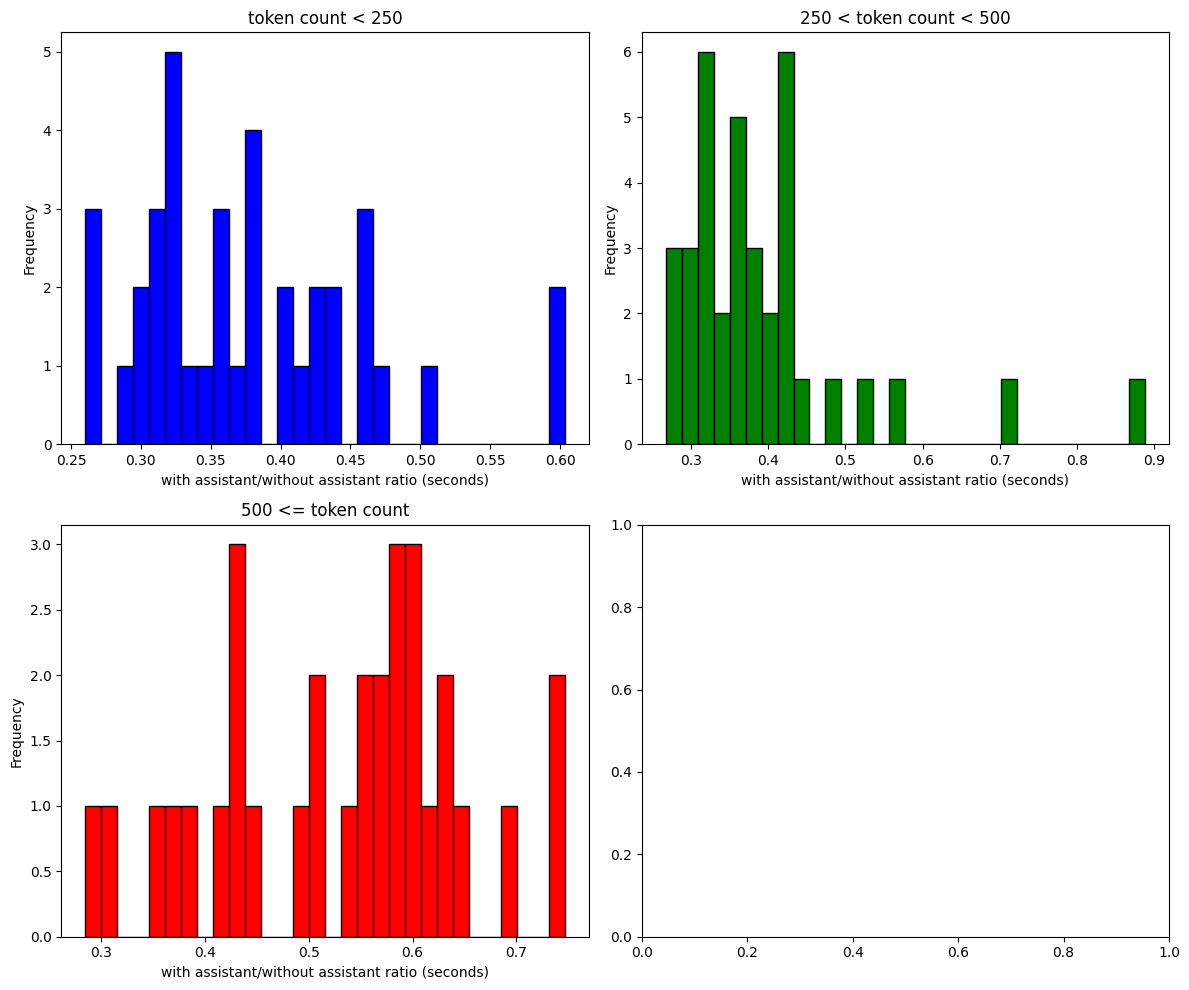

Average speedup ratio:  0.4288983459264465
Average time with assistant:  47.120585547210204
Average time without assistant:  127.47785398812876
Average time with assistant (over 500 tkns) 25.32991455206948
Average time without assistant (over 500 tkns) 54.91771576595643
Average speedup ratio (over 500 tkns):  0.5303773212084943


  0%|                                                                              | 0/105 [00:00<?, ?it/s]

Finished with assistant


  1%|▋                                                                     | 1/105 [00:34<59:57, 34.59s/it]

Finished with assistant


  2%|█▎                                                                 | 2/105 [07:50<7:44:20, 270.49s/it]

Finished with assistant


  3%|█▉                                                                 | 3/105 [08:50<4:56:50, 174.62s/it]

Finished with assistant


  4%|██▌                                                                | 4/105 [10:51<4:18:25, 153.52s/it]

Finished with assistant


  5%|███▏                                                               | 5/105 [14:33<4:56:36, 177.96s/it]

Finished with assistant


  6%|███▊                                                               | 6/105 [17:03<4:38:06, 168.55s/it]

Finished with assistant


  7%|████▍                                                              | 7/105 [18:20<3:46:18, 138.55s/it]

Finished with assistant


  8%|█████                                                              | 8/105 [21:29<4:09:50, 154.54s/it]

Finished with assistant


  9%|█████▋                                                             | 9/105 [22:35<3:22:59, 126.87s/it]

Finished with assistant


 10%|██████▎                                                           | 10/105 [24:50<3:25:08, 129.56s/it]

Finished with assistant


 10%|██████▉                                                           | 11/105 [28:44<4:12:56, 161.45s/it]

Finished with assistant


 11%|███████▌                                                          | 12/105 [32:45<4:47:45, 185.65s/it]

Finished with assistant


 12%|████████▏                                                         | 13/105 [33:14<3:32:06, 138.33s/it]

Finished with assistant


 13%|████████▊                                                         | 14/105 [34:40<3:05:47, 122.49s/it]

Finished with assistant


 14%|█████████▍                                                        | 15/105 [37:27<3:23:43, 135.82s/it]

Finished with assistant


 15%|██████████                                                        | 16/105 [38:24<2:46:08, 112.01s/it]

Finished with assistant


 16%|██████████▋                                                       | 17/105 [42:04<3:32:12, 144.69s/it]

Finished with assistant


 17%|███████████▎                                                      | 18/105 [46:29<4:21:55, 180.64s/it]

Finished with assistant


 18%|███████████▉                                                      | 19/105 [47:31<3:27:56, 145.07s/it]

Finished with assistant


 19%|████████████▌                                                     | 20/105 [51:51<4:14:19, 179.52s/it]

Finished with assistant


 20%|█████████████▏                                                    | 21/105 [52:43<3:17:43, 141.23s/it]

Finished with assistant


 21%|█████████████▊                                                    | 22/105 [59:24<5:03:09, 219.15s/it]

Finished with assistant


 22%|██████████████                                                  | 23/105 [1:00:28<3:56:10, 172.81s/it]

Finished with assistant


 23%|██████████████▋                                                 | 24/105 [1:06:38<5:13:04, 231.91s/it]

Finished with assistant


 24%|███████████████▏                                                | 25/105 [1:18:21<8:17:37, 373.22s/it]

Finished with assistant


 25%|███████████████▊                                                | 26/105 [1:19:16<6:05:53, 277.90s/it]

Finished with assistant


 26%|████████████████▍                                               | 27/105 [1:25:40<6:42:30, 309.62s/it]

Finished with assistant


 27%|█████████████████                                               | 28/105 [1:31:09<6:44:41, 315.34s/it]

Finished with assistant


 28%|█████████████████▋                                              | 29/105 [1:34:37<5:58:35, 283.10s/it]

Finished with assistant


 29%|██████████████████▎                                             | 30/105 [1:34:58<4:15:53, 204.71s/it]

Finished with assistant


 30%|██████████████████▉                                             | 31/105 [1:35:52<3:16:29, 159.32s/it]

Finished with assistant


 30%|███████████████████▌                                            | 32/105 [1:39:48<3:41:57, 182.43s/it]

Finished with assistant


 31%|████████████████████                                            | 33/105 [1:40:19<2:44:12, 136.84s/it]

Finished with assistant


 32%|████████████████████▋                                           | 34/105 [1:42:25<2:38:12, 133.70s/it]

Finished with assistant


 33%|█████████████████████▎                                          | 35/105 [1:44:34<2:34:19, 132.28s/it]

Finished with assistant


 34%|█████████████████████▉                                          | 36/105 [1:49:32<3:29:24, 182.09s/it]

Finished with assistant


 35%|██████████████████████▌                                         | 37/105 [1:55:41<4:29:49, 238.08s/it]

Finished with assistant


 36%|███████████████████████▏                                        | 38/105 [2:00:09<4:35:53, 247.06s/it]

Finished with assistant


 37%|███████████████████████▊                                        | 39/105 [2:00:39<3:20:11, 181.99s/it]

Finished with assistant


 38%|████████████████████████▍                                       | 40/105 [2:06:21<4:09:09, 229.99s/it]

Finished with assistant


 39%|████████████████████████▉                                       | 41/105 [2:11:01<4:21:16, 244.95s/it]

Finished with assistant


 40%|█████████████████████████▌                                      | 42/105 [2:15:24<4:22:48, 250.30s/it]

Finished with assistant


 41%|██████████████████████████▏                                     | 43/105 [2:16:14<3:16:38, 190.31s/it]

Finished with assistant


 42%|██████████████████████████▊                                     | 44/105 [2:19:22<3:12:38, 189.49s/it]

Finished with assistant


 43%|███████████████████████████▍                                    | 45/105 [2:20:01<2:24:17, 144.30s/it]

Finished with assistant


 44%|████████████████████████████                                    | 46/105 [2:22:23<2:21:22, 143.76s/it]

Finished with assistant


 45%|████████████████████████████▋                                   | 47/105 [2:23:19<1:53:31, 117.43s/it]

Finished with assistant


 46%|█████████████████████████████▎                                  | 48/105 [2:26:56<2:19:53, 147.25s/it]

Finished with assistant


 47%|█████████████████████████████▊                                  | 49/105 [2:30:25<2:34:51, 165.93s/it]

Finished with assistant


 48%|██████████████████████████████▍                                 | 50/105 [2:30:51<1:53:36, 123.94s/it]

Finished with assistant


 49%|███████████████████████████████                                 | 51/105 [2:38:17<3:18:24, 220.46s/it]

Finished with assistant


 50%|███████████████████████████████▋                                | 52/105 [2:44:06<3:48:43, 258.94s/it]

Finished with assistant


 50%|████████████████████████████████▎                               | 53/105 [2:47:35<3:31:35, 244.15s/it]

Finished with assistant


 51%|████████████████████████████████▉                               | 54/105 [2:48:54<2:45:17, 194.46s/it]

Finished with assistant


 52%|█████████████████████████████████▌                              | 55/105 [2:51:57<2:39:07, 190.96s/it]

Finished with assistant


 53%|██████████████████████████████████▏                             | 56/105 [2:56:05<2:50:01, 208.19s/it]

Finished with assistant


 54%|██████████████████████████████████▋                             | 57/105 [3:01:07<3:09:06, 236.38s/it]

Finished with assistant


 55%|███████████████████████████████████▎                            | 58/105 [3:05:04<3:05:19, 236.58s/it]

Finished with assistant


 56%|███████████████████████████████████▉                            | 59/105 [3:08:49<2:58:31, 232.86s/it]

Finished with assistant


 57%|████████████████████████████████████▌                           | 60/105 [3:12:50<2:56:33, 235.41s/it]

Finished with assistant


 58%|█████████████████████████████████████▏                          | 61/105 [3:18:54<3:20:52, 273.92s/it]

Finished with assistant


 59%|█████████████████████████████████████▊                          | 62/105 [3:24:00<3:23:14, 283.60s/it]

Finished with assistant


 60%|██████████████████████████████████████▍                         | 63/105 [3:26:16<2:47:37, 239.46s/it]

Finished with assistant


 61%|███████████████████████████████████████                         | 64/105 [3:29:40<2:36:14, 228.65s/it]

Finished with assistant


 62%|███████████████████████████████████████▌                        | 65/105 [3:33:22<2:31:12, 226.82s/it]

Finished with assistant


 63%|████████████████████████████████████████▏                       | 66/105 [3:33:58<1:50:07, 169.43s/it]

Finished with assistant


 64%|████████████████████████████████████████▊                       | 67/105 [3:37:00<1:49:45, 173.31s/it]

Finished with assistant


 65%|█████████████████████████████████████████▍                      | 68/105 [3:40:48<1:56:54, 189.58s/it]

Finished with assistant


 66%|██████████████████████████████████████████                      | 69/105 [3:41:23<1:26:00, 143.35s/it]

Finished with assistant


 67%|██████████████████████████████████████████▋                     | 70/105 [3:44:09<1:27:35, 150.17s/it]

Finished with assistant


 68%|███████████████████████████████████████████▎                    | 71/105 [3:44:39<1:04:40, 114.12s/it]

Finished with assistant


 69%|███████████████████████████████████████████▉                    | 72/105 [3:49:19<1:30:03, 163.74s/it]

Finished with assistant


 70%|████████████████████████████████████████████▍                   | 73/105 [3:52:31<1:31:54, 172.33s/it]

Finished with assistant


 70%|█████████████████████████████████████████████                   | 74/105 [3:55:44<1:32:14, 178.54s/it]

Finished with assistant


 71%|█████████████████████████████████████████████▋                  | 75/105 [3:56:05<1:05:33, 131.13s/it]

Finished with assistant


 72%|██████████████████████████████████████████████▎                 | 76/105 [4:00:16<1:20:46, 167.12s/it]

Finished with assistant


 73%|██████████████████████████████████████████████▉                 | 77/105 [4:01:05<1:01:30, 131.82s/it]

Finished with assistant


 74%|█████████████████████████████████████████████████                 | 78/105 [4:03:14<58:55, 130.93s/it]

Finished with assistant


 75%|████████████████████████████████████████████████▏               | 79/105 [4:12:59<1:55:46, 267.16s/it]

Finished with assistant


 76%|████████████████████████████████████████████████▊               | 80/105 [4:17:38<1:52:43, 270.54s/it]

Finished with assistant


 77%|█████████████████████████████████████████████████▎              | 81/105 [4:20:30<1:36:26, 241.11s/it]

Finished with assistant


 78%|█████████████████████████████████████████████████▉              | 82/105 [4:23:59<1:28:42, 231.41s/it]

Finished with assistant


 79%|██████████████████████████████████████████████████▌             | 83/105 [4:27:05<1:19:54, 217.92s/it]

Finished with assistant


 80%|███████████████████████████████████████████████████▏            | 84/105 [4:28:20<1:01:13, 174.95s/it]

Finished with assistant


 81%|█████████████████████████████████████████████████████▍            | 85/105 [4:28:51<43:53, 131.68s/it]

Finished with assistant


 82%|██████████████████████████████████████████████████████            | 86/105 [4:29:49<34:42, 109.61s/it]

Finished with assistant


 83%|██████████████████████████████████████████████████████▋           | 87/105 [4:34:52<50:20, 167.78s/it]

Finished with assistant


 84%|███████████████████████████████████████████████████████▎          | 88/105 [4:38:31<51:50, 182.99s/it]

Finished with assistant


 85%|███████████████████████████████████████████████████████▉          | 89/105 [4:39:23<38:19, 143.70s/it]

Finished with assistant


 86%|████████████████████████████████████████████████████████▌         | 90/105 [4:39:57<27:41, 110.74s/it]

Finished with assistant


 87%|█████████████████████████████████████████████████████████▏        | 91/105 [4:41:55<26:23, 113.09s/it]

Finished with assistant


 88%|█████████████████████████████████████████████████████████▊        | 92/105 [4:45:43<31:58, 147.55s/it]

Finished with assistant


 89%|██████████████████████████████████████████████████████████▍       | 93/105 [4:46:44<24:20, 121.69s/it]

Finished with assistant


 90%|███████████████████████████████████████████████████████████       | 94/105 [4:47:38<18:33, 101.25s/it]

Finished with assistant


 90%|███████████████████████████████████████████████████████████▋      | 95/105 [4:51:28<23:18, 139.86s/it]

Finished with assistant


 91%|████████████████████████████████████████████████████████████▎     | 96/105 [4:58:00<32:19, 215.50s/it]

Finished with assistant


 92%|████████████████████████████████████████████████████████████▉     | 97/105 [4:58:27<21:12, 159.10s/it]

Finished with assistant


 93%|█████████████████████████████████████████████████████████████▌    | 98/105 [5:03:18<23:08, 198.41s/it]

Finished with assistant


 94%|██████████████████████████████████████████████████████████████▏   | 99/105 [5:03:49<14:49, 148.26s/it]

Finished with assistant


 95%|█████████████████████████████████████████████████████████████▉   | 100/105 [5:06:17<12:21, 148.22s/it]

Finished with assistant


 96%|██████████████████████████████████████████████████████████████▌  | 101/105 [5:07:38<08:32, 128.06s/it]

Finished with assistant


 97%|███████████████████████████████████████████████████████████████▏ | 102/105 [5:11:29<07:56, 158.96s/it]

Finished with assistant


 98%|███████████████████████████████████████████████████████████████▊ | 103/105 [5:17:09<07:06, 213.34s/it]

Finished with assistant


 99%|████████████████████████████████████████████████████████████████▍| 104/105 [5:21:11<03:41, 221.74s/it]

Finished with assistant


100%|█████████████████████████████████████████████████████████████████| 105/105 [5:24:06<00:00, 185.20s/it]


Analysis for lookup tokens:  80


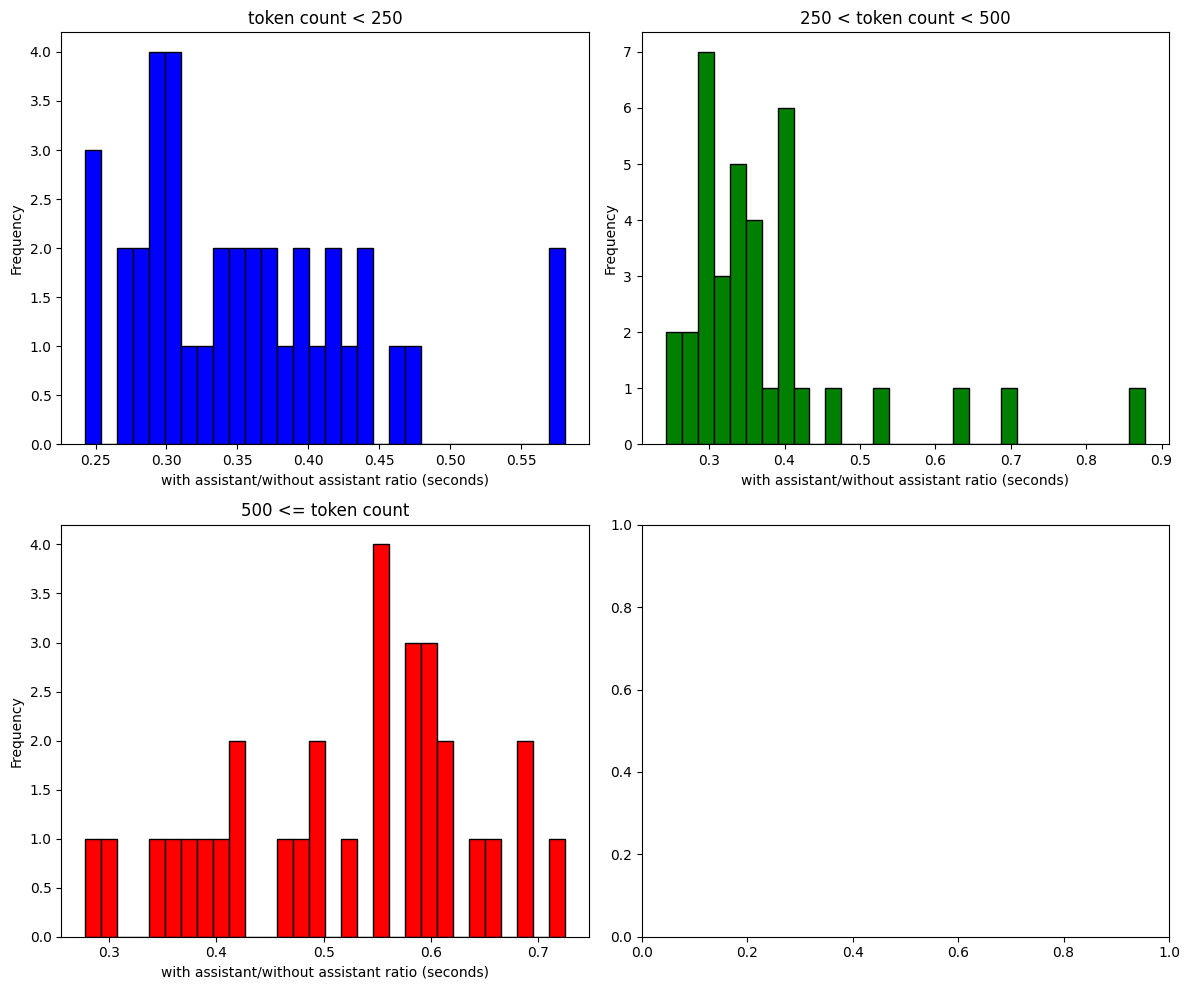

Average speedup ratio:  0.41243110928612864
Average time with assistant:  47.89691594250145
Average time without assistant:  137.30174970900018
Average time with assistant (over 500 tkns) 25.608710826104208
Average time without assistant (over 500 tkns) 57.38250733809846
Average speedup ratio (over 500 tkns):  0.5200554707245035


  0%|                                                                              | 0/105 [00:00<?, ?it/s]

Finished with assistant


  1%|▋                                                                   | 1/105 [00:41<1:12:21, 41.74s/it]

Finished with assistant


  2%|█▎                                                                 | 2/105 [08:02<7:54:28, 276.39s/it]

Finished with assistant


  3%|█▉                                                                 | 3/105 [09:06<5:05:22, 179.63s/it]

Finished with assistant


  4%|██▌                                                                | 4/105 [11:23<4:33:30, 162.48s/it]

Finished with assistant


  5%|███▏                                                               | 5/105 [15:51<5:34:27, 200.68s/it]

Finished with assistant


  6%|███▊                                                               | 6/105 [18:56<5:22:14, 195.30s/it]

Finished with assistant


  7%|████▍                                                              | 7/105 [20:33<4:26:26, 163.13s/it]

Finished with assistant


  8%|█████                                                              | 8/105 [24:29<5:01:20, 186.40s/it]

Finished with assistant


  9%|█████▋                                                             | 9/105 [25:41<4:01:16, 150.80s/it]

Finished with assistant


 10%|██████▎                                                           | 10/105 [28:22<4:03:24, 153.74s/it]

Finished with assistant


 10%|██████▉                                                           | 11/105 [33:01<5:00:59, 192.12s/it]

Finished with assistant


 11%|███████▌                                                          | 12/105 [37:54<5:45:32, 222.93s/it]

Finished with assistant


 12%|████████▏                                                         | 13/105 [38:24<4:12:05, 164.40s/it]

Finished with assistant


 13%|████████▊                                                         | 14/105 [39:57<3:36:42, 142.88s/it]

Finished with assistant


 14%|█████████▍                                                        | 15/105 [43:10<3:57:02, 158.02s/it]

Finished with assistant


 15%|██████████                                                        | 16/105 [44:12<3:11:18, 128.97s/it]

Finished with assistant


 16%|██████████▋                                                       | 17/105 [48:35<4:08:08, 169.19s/it]

Finished with assistant


 17%|███████████▎                                                      | 18/105 [53:57<5:12:07, 215.25s/it]

Finished with assistant


 18%|███████████▉                                                      | 19/105 [55:04<4:04:48, 170.80s/it]

Finished with assistant


 19%|████████████▌                                                     | 20/105 [59:40<4:46:38, 202.34s/it]

Finished with assistant


 20%|████████████▊                                                   | 21/105 [1:00:36<3:41:39, 158.32s/it]

Finished with assistant


 21%|█████████████▍                                                  | 22/105 [1:08:38<5:53:29, 255.54s/it]

Finished with assistant


 22%|██████████████                                                  | 23/105 [1:09:47<4:32:44, 199.57s/it]

Finished with assistant


 23%|██████████████▋                                                 | 24/105 [1:17:17<6:10:42, 274.60s/it]

Finished with assistant


 24%|███████████████                                                | 25/105 [1:31:55<10:07:27, 455.60s/it]

Finished with assistant


 25%|███████████████▊                                                | 26/105 [1:32:59<7:25:22, 338.26s/it]

Finished with assistant


 26%|████████████████▍                                               | 27/105 [1:41:03<8:16:42, 382.09s/it]

Finished with assistant


 27%|█████████████████                                               | 28/105 [1:47:36<8:14:27, 385.30s/it]

Finished with assistant


 28%|█████████████████▋                                              | 29/105 [1:51:49<7:17:46, 345.61s/it]

Finished with assistant


 29%|██████████████████▎                                             | 30/105 [1:52:15<5:11:59, 249.60s/it]

Finished with assistant


 30%|██████████████████▉                                             | 31/105 [1:53:16<3:58:15, 193.18s/it]

Finished with assistant


 30%|███████████████████▌                                            | 32/105 [1:57:59<4:27:52, 220.16s/it]

Finished with assistant


 31%|████████████████████                                            | 33/105 [1:58:30<3:16:04, 163.40s/it]

Finished with assistant


 32%|████████████████████▋                                           | 34/105 [2:00:56<3:06:55, 157.96s/it]

Finished with assistant


 33%|█████████████████████▎                                          | 35/105 [2:03:34<3:04:23, 158.04s/it]

Finished with assistant


 34%|█████████████████████▉                                          | 36/105 [2:09:16<4:05:20, 213.34s/it]

Finished with assistant


 35%|██████████████████████▌                                         | 37/105 [2:16:38<5:19:24, 281.83s/it]

Finished with assistant


 36%|███████████████████████▏                                        | 38/105 [2:21:56<5:26:57, 292.80s/it]

Finished with assistant


 37%|███████████████████████▊                                        | 39/105 [2:22:30<3:56:29, 215.00s/it]

Finished with assistant


 38%|████████████████████████▍                                       | 40/105 [2:29:20<4:56:30, 273.70s/it]

Finished with assistant


 39%|████████████████████████▉                                       | 41/105 [2:34:57<5:12:06, 292.61s/it]

Finished with assistant


 40%|█████████████████████████▌                                      | 42/105 [2:40:12<5:14:18, 299.34s/it]

Finished with assistant


 41%|██████████████████████████▏                                     | 43/105 [2:41:03<3:52:17, 224.80s/it]

Finished with assistant


 42%|██████████████████████████▊                                     | 44/105 [2:44:41<3:46:33, 222.84s/it]

Finished with assistant


 43%|███████████████████████████▍                                    | 45/105 [2:45:21<2:47:49, 167.82s/it]

Finished with assistant


 44%|████████████████████████████                                    | 46/105 [2:48:10<2:45:21, 168.17s/it]

Finished with assistant


 45%|████████████████████████████▋                                   | 47/105 [2:49:10<2:11:21, 135.89s/it]

Finished with assistant


 46%|█████████████████████████████▎                                  | 48/105 [2:53:22<2:42:02, 170.56s/it]

Finished with assistant


 47%|█████████████████████████████▊                                  | 49/105 [2:57:37<3:02:57, 196.03s/it]

Finished with assistant


 48%|██████████████████████████████▍                                 | 50/105 [2:58:05<2:13:18, 145.43s/it]

Finished with assistant


 49%|███████████████████████████████                                 | 51/105 [3:07:14<3:59:50, 266.49s/it]

Finished with assistant


 50%|███████████████████████████████▋                                | 52/105 [3:14:14<4:36:13, 312.71s/it]

Finished with assistant


 50%|████████████████████████████████▎                               | 53/105 [3:18:19<4:13:26, 292.44s/it]

Finished with assistant


 51%|████████████████████████████████▉                               | 54/105 [3:19:53<3:17:48, 232.71s/it]

Finished with assistant


 52%|█████████████████████████████████▌                              | 55/105 [3:23:27<3:09:26, 227.33s/it]

Finished with assistant


 53%|██████████████████████████████████▏                             | 56/105 [3:28:29<3:23:48, 249.56s/it]

Finished with assistant


 54%|██████████████████████████████████▋                             | 57/105 [3:34:37<3:48:09, 285.19s/it]

Finished with assistant


 55%|███████████████████████████████████▎                            | 58/105 [3:39:34<3:46:10, 288.74s/it]

Finished with assistant


 56%|███████████████████████████████████▉                            | 59/105 [3:44:05<3:37:14, 283.35s/it]

Finished with assistant


 57%|████████████████████████████████████▌                           | 60/105 [3:49:03<3:35:54, 287.89s/it]

Finished with assistant


 58%|█████████████████████████████████████▏                          | 61/105 [3:56:10<4:01:35, 329.43s/it]

Finished with assistant


 59%|█████████████████████████████████████▊                          | 62/105 [4:02:16<4:03:53, 340.31s/it]

Finished with assistant


 60%|██████████████████████████████████████▍                         | 63/105 [4:04:59<3:21:07, 287.31s/it]

Finished with assistant


 61%|███████████████████████████████████████                         | 64/105 [4:09:09<3:08:34, 275.96s/it]

Finished with assistant


 62%|███████████████████████████████████████▌                        | 65/105 [4:13:33<3:01:43, 272.60s/it]

Finished with assistant


 63%|████████████████████████████████████████▏                       | 66/105 [4:14:06<2:10:27, 200.72s/it]

With assistant time > w/o assistant 16.696410298347473 16.292696284130216
Finished with assistant


 64%|████████████████████████████████████████▊                       | 67/105 [4:17:41<2:09:42, 204.81s/it]

Finished with assistant


 65%|█████████████████████████████████████████▍                      | 68/105 [4:22:12<2:18:29, 224.59s/it]

Finished with assistant


 66%|██████████████████████████████████████████                      | 69/105 [4:22:49<1:41:01, 168.36s/it]

Finished with assistant


 67%|██████████████████████████████████████████▋                     | 70/105 [4:26:42<1:49:39, 188.00s/it]

Finished with assistant


 68%|███████████████████████████████████████████▎                    | 71/105 [4:27:13<1:19:43, 140.70s/it]

Finished with assistant


 69%|███████████████████████████████████████████▉                    | 72/105 [4:32:51<1:50:00, 200.03s/it]

Finished with assistant


 70%|████████████████████████████████████████████▍                   | 73/105 [4:36:36<1:50:36, 207.39s/it]

Finished with assistant


 70%|█████████████████████████████████████████████                   | 74/105 [4:40:28<1:50:58, 214.79s/it]

Finished with assistant


 71%|█████████████████████████████████████████████▋                  | 75/105 [4:40:50<1:18:25, 156.86s/it]

Finished with assistant


 72%|██████████████████████████████████████████████▎                 | 76/105 [4:45:36<1:34:35, 195.72s/it]

Finished with assistant


 73%|██████████████████████████████████████████████▉                 | 77/105 [4:46:33<1:11:51, 153.98s/it]

Finished with assistant


 74%|███████████████████████████████████████████████▌                | 78/105 [4:48:59<1:08:19, 151.83s/it]

Finished with assistant


 75%|████████████████████████████████████████████████▏               | 79/105 [5:00:45<2:17:50, 318.10s/it]

Finished with assistant


 76%|████████████████████████████████████████████████▊               | 80/105 [5:06:20<2:14:34, 322.98s/it]

Finished with assistant


 77%|█████████████████████████████████████████████████▎              | 81/105 [5:09:29<1:53:06, 282.78s/it]

Finished with assistant


 78%|█████████████████████████████████████████████████▉              | 82/105 [5:13:38<1:44:31, 272.68s/it]

Finished with assistant


 79%|██████████████████████████████████████████████████▌             | 83/105 [5:17:17<1:34:06, 256.66s/it]

Finished with assistant


 80%|███████████████████████████████████████████████████▏            | 84/105 [5:18:43<1:11:51, 205.31s/it]

Finished with assistant


 81%|█████████████████████████████████████████████████████▍            | 85/105 [5:19:13<50:59, 152.96s/it]

Finished with assistant


 82%|██████████████████████████████████████████████████████            | 86/105 [5:20:15<39:43, 125.43s/it]

Finished with assistant


 83%|██████████████████████████████████████████████████████▋           | 87/105 [5:26:22<59:22, 197.94s/it]

Finished with assistant


 84%|█████████████████████████████████████████████████████▋          | 88/105 [5:30:37<1:00:55, 215.01s/it]

Finished with assistant


 85%|███████████████████████████████████████████████████████▉          | 89/105 [5:31:33<44:38, 167.43s/it]

Finished with assistant


 86%|████████████████████████████████████████████████████████▌         | 90/105 [5:32:07<31:50, 127.37s/it]

Finished with assistant


 87%|█████████████████████████████████████████████████████████▏        | 91/105 [5:34:24<30:23, 130.24s/it]

Finished with assistant


 88%|█████████████████████████████████████████████████████████▊        | 92/105 [5:39:05<38:00, 175.42s/it]

Finished with assistant


 89%|██████████████████████████████████████████████████████████▍       | 93/105 [5:40:07<28:15, 141.33s/it]

Finished with assistant


 90%|███████████████████████████████████████████████████████████       | 94/105 [5:41:03<21:13, 115.81s/it]

Finished with assistant


 90%|███████████████████████████████████████████████████████████▋      | 95/105 [5:45:38<27:15, 163.56s/it]

Finished with assistant


 91%|████████████████████████████████████████████████████████████▎     | 96/105 [5:53:39<38:50, 258.92s/it]

Finished with assistant


 92%|████████████████████████████████████████████████████████████▉     | 97/105 [5:54:07<25:15, 189.48s/it]

Finished with assistant


 93%|█████████████████████████████████████████████████████████████▌    | 98/105 [5:59:50<27:30, 235.77s/it]

Finished with assistant


 94%|██████████████████████████████████████████████████████████████▏   | 99/105 [6:00:21<17:26, 174.34s/it]

Finished with assistant


 95%|█████████████████████████████████████████████████████████████▉   | 100/105 [6:03:13<14:28, 173.64s/it]

Finished with assistant


 96%|██████████████████████████████████████████████████████████████▌  | 101/105 [6:04:46<09:57, 149.35s/it]

Finished with assistant


 97%|███████████████████████████████████████████████████████████████▏ | 102/105 [6:09:16<09:16, 185.55s/it]

Finished with assistant


 98%|███████████████████████████████████████████████████████████████▊ | 103/105 [6:16:02<08:23, 251.53s/it]

Finished with assistant


 99%|████████████████████████████████████████████████████████████████▍| 104/105 [6:20:50<04:22, 262.48s/it]

Finished with assistant


100%|█████████████████████████████████████████████████████████████████| 105/105 [6:24:12<00:00, 219.55s/it]


Analysis for lookup tokens:  160


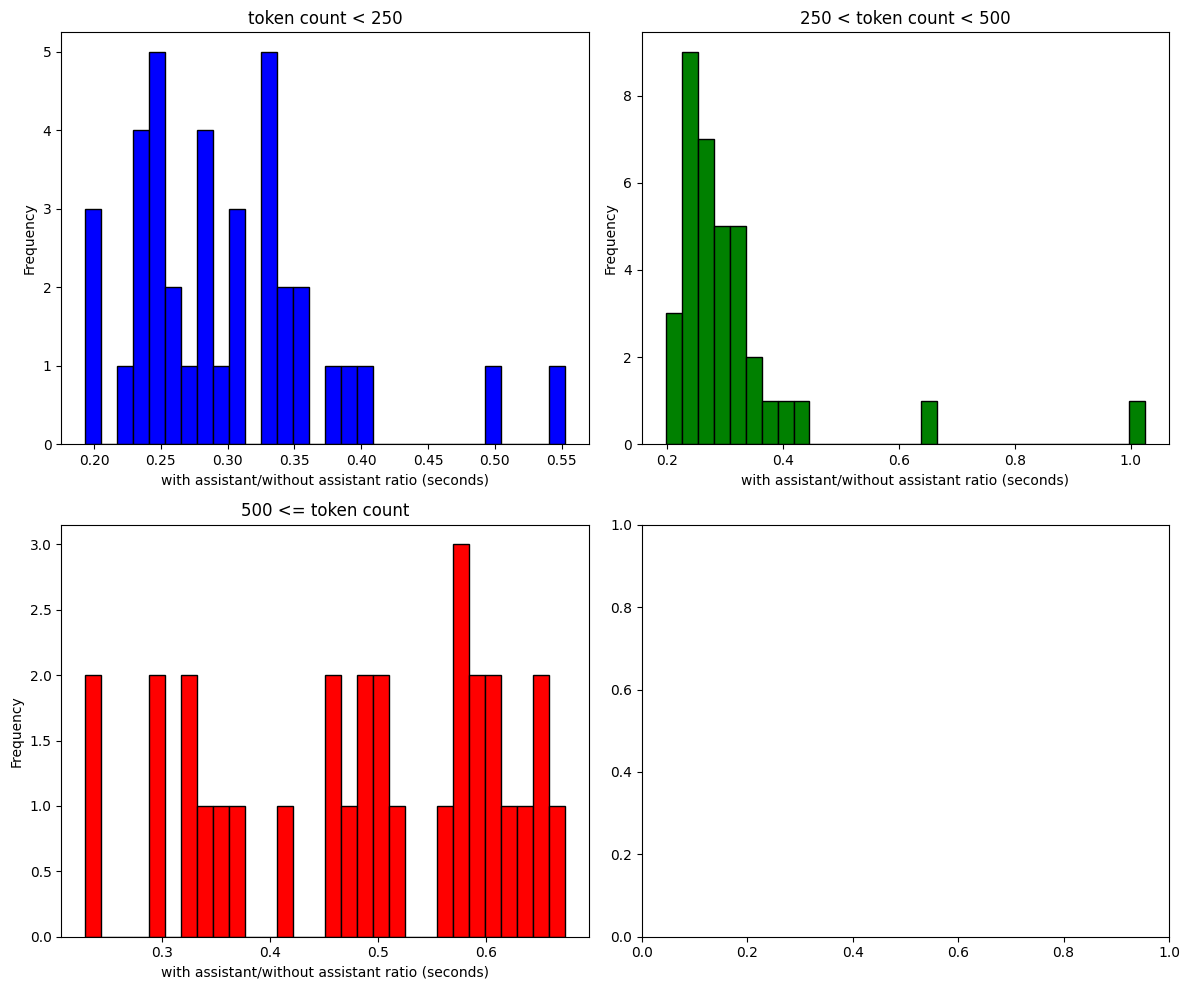

Average speedup ratio:  0.35929241903733233
Average time with assistant:  49.0380081849084
Average time without assistant:  170.50343794045705
Average time with assistant (over 500 tkns) 26.04943946658844
Average time without assistant (over 500 tkns) 66.76839009287858
Average speedup ratio (over 500 tkns):  0.4837271318090021


In [31]:
lookup_tokens = [40, 80, 160]
time_taken = {x: {"with_assistant": [], "without_assistant": []} for x in lookup_tokens}
outputs = {x: {"with_assistant": [], "without_assistant": []} for x in lookup_tokens}
for lt in lookup_tokens:
    for row in tqdm(ds):
        input_text = "## Code Before:\n{code_text}\n## Change requested: {question}\n## Rewrite the code to incorporate the change.\n".format(code_text=row['before'], question=row['instruction_descriptive'])
        # inputs = tokenizer(input_text, return_tensors="pt")
        inputs = tokenizer.apply_chat_template([
            {
                "role": "user",
                "content": input_text
            }
        ], tokenize=True, add_generation_prompt=True, return_tensors="pt").to(model.device)
        # for key in inputs:
        #     inputs[key] = inputs[key].to(model.device)
        code_ids = tokenizer(row['before'], return_tensors="pt").input_ids[0].tolist()

        max_new_token = inputs.shape[-1] + 300
        # max_new_tokens = inputs['input_ids'].shape[-1] + 300
    
        start_time = time.perf_counter()
        test_out = model.greedy_search_assistant_pld(inputs, #inputs.input_ids,
                        code_ids,
                        draft_model,
                      # attention_mask = inputs.attention_mask,
                      stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs) + max_new_tokens)]),
                    assistant_prompt_matching_window_size = 3,
                    assistant_prompt_candidate_tokens = lt,
                    assistant_draft_candidate_rounds = 6,
                    max_draft_num_candidate_tokens = 1000,
                      use_cache=True, 
                      pad_token_id=tokenizer.pad_token_id,
                      eos_token_id=tokenizer.eos_token_id,
                    print_output=False,
                    seed=10
                )
        end_time = time.perf_counter()

        print("Finished with assistant")
    
        time_taken[lt]["with_assistant"].append(end_time - start_time)
        outputs[lt]["with_assistant"].append(tokenizer.batch_decode(test_out))
    
        start_time = time.perf_counter()
        test_out = model.greedy_search_pld(inputs, #inputs.input_ids,
                        code_ids,
                      # attention_mask = inputs.attention_mask,
                      stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs) + max_new_tokens)]),
                    draft_matching_window_size = 3,
                    draft_num_candidate_tokens = lt,
                      use_cache=True, 
                      pad_token_id=tokenizer.pad_token_id,
                      eos_token_id=tokenizer.eos_token_id,
                     print_output=False,
                    seed=10
                )
        end_time = time.perf_counter()
        
        time_taken[lt]["without_assistant"].append(end_time - start_time)
        outputs[lt]["without_assistant"].append(tokenizer.batch_decode(test_out))

        if time_taken[lt]["with_assistant"][-1] > time_taken[lt]["without_assistant"][-1]:
            print("With assistant time > w/o assistant", time_taken[lt]["with_assistant"][-1], time_taken[lt]["without_assistant"][-1])
    print("Analysis for lookup tokens: ", lt)
    show_token_split_graphs(time_taken[lt], token_count)

In [32]:
time_taken

{40: {'with_assistant': [7.2117172088474035,
   92.43106105923653,
   24.546892508864403,
   26.483610106632113,
   50.39487604238093,
   38.10053307004273,
   17.69963938370347,
   39.528524899855256,
   19.288919435814023,
   38.44172819331288,
   49.964863486588,
   55.83694069646299,
   11.539172912016511,
   26.677080469205976,
   42.31440705060959,
   20.855806078761816,
   49.18825720436871,
   60.61188576743007,
   21.14502022601664,
   66.44521133601665,
   17.807648569345474,
   91.19039302691817,
   21.255360659211874,
   72.00198636576533,
   162.2007982544601,
   15.906713338568807,
   75.56727588362992,
   76.64553595893085,
   55.36421298980713,
   6.581117924302816,
   13.908998094499111,
   59.33101543225348,
   11.315277636051178,
   29.297232491895556,
   32.26757650449872,
   84.53855220414698,
   91.30049663223326,
   64.22229590266943,
   11.054560989141464,
   79.33959202468395,
   71.31260465085506,
   73.09100927971303,
   17.944275377318263,
   42.151059193536

In [ ]:
# Find the optimal for each
import numpy as np
import matplotlib.pyplot as plt

z = np.array(token_count)  
r = np.array(list(range(len(z))))
subsets = [r[z < 250], r[(z >= 250) & (z < 500)], r[(z >= 500) & (z < 1000)], r[z >= 1000]]
ssnames  = ["less than 250", "250 to 500", "500 to 1000", "over 1000"]
for ssname, subset in zip(ssnames, subsets):

    sratio = []

    for idx in subset:
        # print(idx)
        best_without_assistant = 1000000
        best_with_assistant = 10000000
    
        best_lookup_without_assistant = 0
        best_lookup_with_assistant = 0

        for lt in lookup_tokens:
            if time_taken[lt]["without_assistant"][idx] < best_without_assistant:
                best_without_assistant = time_taken[lt]["without_assistant"][idx]
                best_lookup_without_assistant = lt
            if time_taken[lt]["with_assistant"][idx] < best_without_assistant:
                best_with_assistant = time_taken[lt]["with_assistant"][idx]
                best_lookup_with_assistant = lt

    
        sratio.append(best_with_assistant/best_without_assistant)
        if sratio[-1] > 1:
            print("Without assistant : ", best_without_assistant, " lookup val: ",  best_lookup_without_assistant, " With assistant: ", best_with_assistant," lookup val: ", best_lookup_with_assistant, "<- greater" if best_with_assistant/best_without_assistant > 1 else "")
    plt.title(ssname)
    plt.hist(sratio, bins=80)
    plt.show()

In [ ]:
# sum(time_taken['with_assistant'])

In [ ]:
# sum(time_taken['without_assistant'])

In [ ]:
ratios = []
assisted_sum = 0
non_assisted_sum = 0
for idx, (i, j) in enumerate(zip(time_taken['with_assistant'], time_taken['without_assistant'])):
    ratios.append(i / j)
    if i / j > 1:
        print(outputs['with_assistant'][idx][0])
        if not(outputs['with_assistant'][idx][0] == outputs['without_assistant'][idx][0]):
            print("ERROR - with assistant and without assistant have different results. Without assistant:\n")
            print(outputs["without_assistant"][idx][0])
        print("============")
    else:
        assisted_sum += i
        non_assisted_sum += j
print(ratios)

In [ ]:
import difflib

count = 0
for wa, woa in zip(outputs['with_assistant'], outputs['without_assistant']):
    if not(wa[0] == woa[0]):
        count += 1
        print("Discrepancy: ")
        print("\n".join(difflib.unified_diff(woa[0].splitlines(), wa[0].splitlines())))

print(count)

In [ ]:
print(assisted_sum, non_assisted_sum, assisted_sum/non_assisted_sum)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ratios, bins=80)
plt.show()

In [ ]:
show_token_split_graphs(time_taken, token_count)

In [ ]:
# Create scatter plots
plt.scatter(token_count, time_taken[80]["with_assistant"], color='blue', label='w/ assistant')
plt.scatter(token_count, time_taken[80]["without_assistant"], color='red', label='no assistant')

# Add title and labels
plt.title('Scatter Plot')
plt.xlabel('Code tokens')
plt.ylabel('Time taken')

# Add legend
plt.legend()
plt.show()